In [ ]:
!nvidia-smi

Sat Dec 12 18:11:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='1ys8y0GKKIWKb6J5yzoOBjIkqFI4a6DhZ', dest_path='./extracted_data.zip', unzip=True)
# gdd.download_file_from_google_drive(file_id='1lVu1gRTFw50idAcqdJW7qZ3GwgE348nj', dest_path='./extracted_data_road.zip', unzip=True)
# gdd.download_file_from_google_drive(file_id='1RuiCItd34DJkmoENVdeTNdokkiBEfSAd', dest_path='./merged_data_road.zip', unzip=True)
gdd.download_file_from_google_drive(file_id='1Yk0eWMWGxeMROvrJ4QTrXTULLwQifLMl', dest_path='./merged_data_road_v2.zip', unzip=True)
gdd.download_file_from_google_drive(file_id='1KyPiolpOxGvKLo8CBwVxF0pDgGGpxR4S', dest_path='./merged_data_lane.zip', unzip=True)

gdd.download_file_from_google_drive(file_id='1ljXGlPkGe8H8naZv2UgO8cbchOHoGMec', dest_path='./mobilenet_unet.pth', unzip=False)

Unzipping...Done.
Unzipping...Done.


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2

class UNet(nn.Module):

    def __init__(self, n_classes, backbone_pretrained=False):
        super(UNet, self).__init__()

        def conv_transpose(in_channels, out_channels, kernel_size, stride, padding, activation_fn=nn.ReLU):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                activation_fn()
            )
        
        def decode_block(in_channels, out_channels):
            return nn.Sequential(
                conv_transpose(2 * in_channels, in_channels, 3, 1, 1),
                conv_transpose(in_channels, out_channels, 3, 1, 1),
                conv_transpose(out_channels, out_channels, 2, 2, 0)
            )


        self.encoder = mobilenet_v2(backbone_pretrained).features

        for decoder_index in range(2):

            decoder = [
                conv_transpose(1280, 320, 3, 1, 1)
            ]

            channel_list = [320, 192, 64, 24, 16, 4]

            for i in range(len(channel_list) - 1):
                in_channels = channel_list[i]
                out_channels = channel_list[i+1]
                decoder.append(decode_block(in_channels, out_channels))

            decoder.append(
                nn.Sequential(
                    conv_transpose(channel_list[-1], n_classes, 3, 1, 1, nn.Sigmoid)
                )
            )

            decoder = nn.Sequential(*decoder)

            if decoder_index == 0:
                self.decoder_0 = decoder
            else:
                self.decoder_1 = decoder

    
    def forward(self, x):

        self.concat_features = []

        for index, block in enumerate(self.encoder):
            x = block(x)
            if index in [1, 3, 5, 6, 12, 13, 17]:
                self.concat_features.append(x)

        decoders = [self.decoder_0, self.decoder_1]

        z = x

        for index, decoder in enumerate(decoders):
            x = z
            concat_features = self.concat_features.copy()

            x = decoder[0](x)

            for i in range(1, len(decoder)-1):

                if i in [2, 3]:
                    x = torch.cat([x, concat_features[-1], concat_features[-2]], 1)
                    concat_features.pop()
                    concat_features.pop()
                else:
                    x = torch.cat([x, concat_features[-1]], 1)
                    concat_features.pop()
                x = decoder[i](x)
            
            x = decoder[-1](x)

            if index == 0:
                x_0 = x
            else:
                x_1 = x

        return x_0, x_1

In [ ]:
import os

import torch
from torch.utils.data import Dataset
import torchvision.transforms as tr

from PIL import Image

class DiRa(Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root

        self.split = split
        self.transform = transform

        # self.img_folder = os.path.join(self.root, self.split, 'images')
        self.img_folder = os.path.join(self.root, 'img_data')

        # self.gt_folder = os.path.join(self.root, self.split, 'ground_truths')
        self.gt_folder = os.path.join(self.root, 'gt_data')

        self.images = os.listdir(self.img_folder)
        self.images.sort()
        self.ground_truths = os.listdir(self.gt_folder)
        self.ground_truths.sort()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_file = os.path.join(self.img_folder, self.images[index])
        img = Image.open(img_file).convert('RGB')

        gt_file = os.path.join(self.gt_folder, self.ground_truths[index])
        gt = Image.open(gt_file).convert('RGB')

        if self.transform != None:
            img = self.transform(img)
            gt = self.transform(gt)

        img = tr.ToTensor()(img)
        gt = tr.ToTensor()(gt)
        gt = gt[2, :, :].unsqueeze(0)

        return img, gt

In [ ]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(DEVICE)

cuda


In [ ]:
try:
  model = torch.load('mobilenet_unet.pth')
except:
  model = UNet(1, True).to(DEVICE)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
dataloader_lane = DataLoader(
        DiRa('/content/merged_data_lane'),
        batch_size=64,
        shuffle=True,
        num_workers=1
    )


In [ ]:
dataloader_road = DataLoader(
        DiRa('/content/merged_data_road_v2'),
        batch_size=64,
        shuffle=True,
        num_workers=1
    )

In [ ]:
criterion = nn.BCELoss()

In [ ]:
optimizer_lane = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
from tqdm.notebook import tqdm

model.train()

for epoch in range(100):
    epoch_loss = 0
    epoch_step = 0
    print('Epoch: {}'.format(epoch + 1))
    for i, (img, gt) in enumerate(tqdm(dataloader_lane)):
    # for i, (img, gt) in enumerate(dataloader_lane):

        optimizer_lane.zero_grad()

        img = img.to(DEVICE)
        gt = gt.to(DEVICE)

        epoch_step += 1

        pred_0, _ = model(img)

        loss = criterion(pred_0, gt)
        loss.backward()
        optimizer_lane.step()

        epoch_loss += loss.item()

    print('Loss: {}'.format(epoch_loss / epoch_step))

Epoch: 1



Loss: 0.009672759204275079
Epoch: 2



Loss: 0.009583565158148606
Epoch: 3



Loss: 0.009804337657988072
Epoch: 4



Loss: 0.00985708458142148
Epoch: 5



Loss: 0.01009824720935689
Epoch: 6



Loss: 0.009836139447159237
Epoch: 7



Loss: 0.009660159175594648
Epoch: 8



Loss: 0.00964529723342922
Epoch: 9



Loss: 0.009618657351368003
Epoch: 10



Loss: 0.010169150452646944
Epoch: 11



Loss: 0.009941247084902393
Epoch: 12



Loss: 0.00990055865711636
Epoch: 13



Loss: 0.009754972635871835
Epoch: 14



Loss: 0.009873935497469372
Epoch: 15



Loss: 0.010544241136974759
Epoch: 16



Loss: 0.009851637813780043
Epoch: 17



Loss: 0.009890887410276467
Epoch: 18



Loss: 0.010041551726559798
Epoch: 19



Loss: 0.009635119202236335
Epoch: 20



Loss: 0.009908241675131851
Epoch: 21



Loss: 0.012254833802580833
Epoch: 22



Loss: 0.010150881463454829
Epoch: 23



Loss: 0.009854975818759866
Epoch: 24



Loss: 0.009700222396188313
Epoch: 25



Loss: 0.009619735471076436
Epoch: 26



Loss: 0.009537567922638521
Epoch: 27



Loss: 0.009578117128047679
Epoch: 28



Loss: 0.009473561081621382
Epoch: 29



Loss: 0.00961402929905388
Epoch: 30



Loss: 0.009772822281552686
Epoch: 31



Loss: 0.009550270189841588
Epoch: 32



Loss: 0.009560290972391765
Epoch: 33



Loss: 0.009640033067100578
Epoch: 34



Loss: 0.009517255301276843
Epoch: 35



Loss: 0.00954625542379088
Epoch: 36



Loss: 0.009871002617809507
Epoch: 37



Loss: 0.00971884009324842
Epoch: 38



Loss: 0.0096166772974862
Epoch: 39



Loss: 0.009647107393377357
Epoch: 40



Loss: 0.009565522977047497
Epoch: 41



Loss: 0.009532483315302267
Epoch: 42



Loss: 0.009628795480562582
Epoch: 43



Loss: 0.00973696160233683
Epoch: 44



Loss: 0.009709734035034974
Epoch: 45



Loss: 0.01019425332132313
Epoch: 46



Loss: 0.013985347271793418
Epoch: 47



Loss: 0.010064417496323586
Epoch: 48



Loss: 0.009819342361556158
Epoch: 49



Loss: 0.009578868912325966
Epoch: 50



Loss: 0.009498887405627304
Epoch: 51



Loss: 0.009474096550709672
Epoch: 52



Loss: 0.009455003382431135
Epoch: 53



Loss: 0.009404217348330551
Epoch: 54



Loss: 0.009370325981742806
Epoch: 55



Loss: 0.009386238890389602
Epoch: 56



Loss: 0.009631472412082884
Epoch: 57



Loss: 0.009642967871493763
Epoch: 58



Loss: 0.009607265703380108
Epoch: 59



Loss: 0.009879193765421708
Epoch: 60



Loss: 0.009962608789404232
Epoch: 61



Loss: 0.00961399512986342
Epoch: 62



Loss: 0.009388252451188035
Epoch: 63



Loss: 0.00946719292551279
Epoch: 64



Loss: 0.009949602455728583
Epoch: 65



Loss: 0.01018840175949865
Epoch: 66



Loss: 0.009901957275966803
Epoch: 67



Loss: 0.009502087988787227
Epoch: 68



Loss: 0.009500896433989207
Epoch: 69



Loss: 0.009531728219654825
Epoch: 70



Loss: 0.009489229880273342
Epoch: 71



Loss: 0.009480489314430289
Epoch: 72



Loss: 0.009435377663208379
Epoch: 73



Loss: 0.00937033204568757
Epoch: 74



Loss: 0.009449050823847453
Epoch: 75



Loss: 0.009348847841223081
Epoch: 76



Loss: 0.009445965021020837
Epoch: 77



Loss: 0.009460954036977555
Epoch: 78



Loss: 0.009484092787735992
Epoch: 79



Loss: 0.009441362135112286
Epoch: 80



Loss: 0.009340930336879359
Epoch: 81



Loss: 0.009396193755997552
Epoch: 82



Loss: 0.009297321654028363
Epoch: 83



Loss: 0.009459710555771987
Epoch: 84



Loss: 0.009387132980757289
Epoch: 85



Loss: 0.009526666833294763
Epoch: 86



Loss: 0.009455468174484042
Epoch: 87



Loss: 0.009597172422541513
Epoch: 88



Loss: 0.009460722655057907
Epoch: 89



Loss: 0.00953843742609024
Epoch: 90



Loss: 0.009763541693488757
Epoch: 91



Loss: 0.009463026664323276
Epoch: 92



Loss: 0.009437212265200084
Epoch: 93



Loss: 0.009360837439695993
Epoch: 94



Loss: 0.009420665788153808
Epoch: 95



Loss: 0.009925489603645272
Epoch: 96



Loss: 0.009601094346079562
Epoch: 97



Loss: 0.009466730575594638
Epoch: 98



Loss: 0.009555897841023075
Epoch: 99



Loss: 0.00949550231711732
Epoch: 100



Loss: 0.009332972744272815


In [ ]:
optimizer_road = optim.Adam(model.decoder_1.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
for epoch in range(100):
    epoch_loss = 0
    epoch_step = 0
    print('Epoch: {}'.format(epoch + 1))
    for i, (img, gt) in enumerate(tqdm(dataloader_road)):
    # for i, (img, gt) in enumerate(dataloader_road):

        optimizer_road.zero_grad()

        img = img.to(DEVICE)
        gt = gt.to(DEVICE)

        epoch_step += 1

        _, pred_1 = model(img)

        loss = criterion(pred_1, gt)
        loss.backward()
        optimizer_road.step()

        epoch_loss += loss.item()

    print('Loss: {}'.format(epoch_loss / epoch_step))

Epoch: 1



Loss: 0.010891506946537384
Epoch: 2



Loss: 0.010592074566629044
Epoch: 3



Loss: 0.01062921265703301
Epoch: 4



Loss: 0.010533183228311151
Epoch: 5



Loss: 0.010561326626948146
Epoch: 6



Loss: 0.010502618694201458
Epoch: 7



Loss: 0.010688603855669498
Epoch: 8



Loss: 0.010581981195786665
Epoch: 9



Loss: 0.010438092681037825
Epoch: 10



Loss: 0.010276241011397784
Epoch: 11



Loss: 0.01024739593700614
Epoch: 12



Loss: 0.010231988266283689
Epoch: 13



Loss: 0.040936107422376786
Epoch: 14



Loss: 0.02585641831852669
Epoch: 15



Loss: 0.01763824392976456
Epoch: 16



Loss: 0.016779803476014803
Epoch: 17



Loss: 0.01350568312891694
Epoch: 18



Loss: 0.012228364254846129
Epoch: 19



Loss: 0.011817290555945662
Epoch: 20



Loss: 0.011379211599570374
Epoch: 21



Loss: 0.011172703943800094
Epoch: 22



Loss: 0.011036267417461373
Epoch: 23



Loss: 0.010921917834080929
Epoch: 24



Loss: 0.010696969124986681
Epoch: 25



Loss: 0.010606729663735213
Epoch: 26



Loss: 0.010396355676443078
Epoch: 27



Loss: 0.010472237110831017
Epoch: 28



Loss: 0.010440346048495103
Epoch: 29



Loss: 0.010316449953892897
Epoch: 30



Loss: 0.01014878605167533
Epoch: 31



Loss: 0.010153279141631237
Epoch: 32



Loss: 0.010095785935084487
Epoch: 33



Loss: 0.01004193097266347
Epoch: 34



Loss: 0.010027646000475385
Epoch: 35



Loss: 0.009933143984093222
Epoch: 36



Loss: 0.00991155317616324
Epoch: 37



Loss: 0.009796283814276373
Epoch: 38



Loss: 0.00980829044656698
Epoch: 39



Loss: 0.009943374952431335
Epoch: 40



Loss: 0.009761978330653768
Epoch: 41



Loss: 0.009693397945442866
Epoch: 42



Loss: 0.009563486611600532
Epoch: 43



Loss: 0.009536733612591443
Epoch: 44



Loss: 0.009659869336458139
Epoch: 45



Loss: 0.011391639471227346
Epoch: 46



Loss: 0.009838946401899638
Epoch: 47



Loss: 0.009512572744211484
Epoch: 48



Loss: 0.009567912603013737
Epoch: 49



Loss: 0.009496602944509928
Epoch: 50



Loss: 0.00976790225696425
Epoch: 51



Loss: 0.009791347523068273
Epoch: 52



Loss: 0.009439903917874014
Epoch: 53



Loss: 0.009320779638581498
Epoch: 54



Loss: 0.009495765100731406
Epoch: 55



Loss: 0.009337706209788488
Epoch: 56



Loss: 0.009297850606746452
Epoch: 57



Loss: 0.009552914237733497
Epoch: 58



Loss: 0.009408132844539575
Epoch: 59



Loss: 0.009281100596972677
Epoch: 60



Loss: 0.009249897500456766
Epoch: 61



Loss: 0.009058062593604243
Epoch: 62



Loss: 0.009095373498492463
Epoch: 63



Loss: 0.009287812530474608
Epoch: 64



Loss: 0.008965630127593528
Epoch: 65



Loss: 0.009140854463154493
Epoch: 66



Loss: 0.009044178501637868
Epoch: 67



Loss: 0.00924005911707185
Epoch: 68



Loss: 0.009194614214086256
Epoch: 69



Loss: 0.012177737516372703
Epoch: 70



Loss: 0.015609247869876929
Epoch: 71



Loss: 0.020378083900310272
Epoch: 72



Loss: 0.012722634667054165
Epoch: 73



Loss: 0.010670290198610273
Epoch: 74



Loss: 0.00967121769695781
Epoch: 75



Loss: 0.009421906000826248
Epoch: 76



Loss: 0.009377888512126235
Epoch: 77



Loss: 0.009093467557672845
Epoch: 78



Loss: 0.00899616063594125
Epoch: 79



Loss: 0.009004205465316772
Epoch: 80



Loss: 0.008931143252655517
Epoch: 81



Loss: 0.008936087427617506
Epoch: 82



Loss: 0.008945270376496537
Epoch: 83



Loss: 0.008849908900988657
Epoch: 84



Loss: 0.008796336800726346
Epoch: 85



Loss: 0.008718238872757484
Epoch: 86



Loss: 0.008766976943196253
Epoch: 87



Loss: 0.008677200619997672
Epoch: 88



Loss: 0.00871687685680944
Epoch: 89



Loss: 0.008715473548617474
Epoch: 90



Loss: 0.00867554536739061
Epoch: 91



Loss: 0.008653748239022355
Epoch: 92



Loss: 0.0085725849819218
Epoch: 93



Loss: 0.008632021338873825
Epoch: 94



Loss: 0.008504498295139435
Epoch: 95



Loss: 0.008552715258109708
Epoch: 96



Loss: 0.008654367319459831
Epoch: 97



Loss: 0.008544358576453009
Epoch: 98



Loss: 0.008509401026246853
Epoch: 99



Loss: 0.008604188817878103
Epoch: 100



Loss: 0.008569077090468518


In [ ]:
import matplotlib.pyplot as plt
import random

dira = DiRa('/content/merged_data_road_v2')

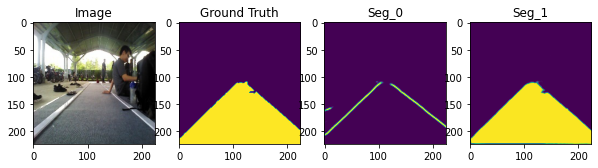

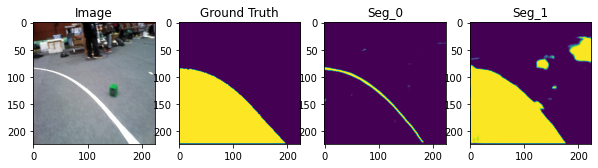

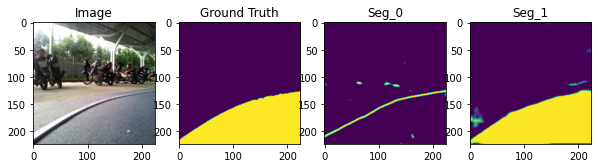

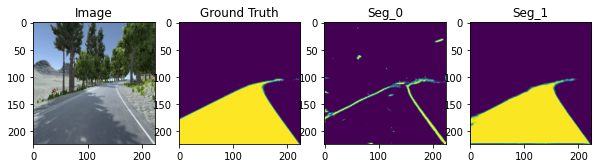

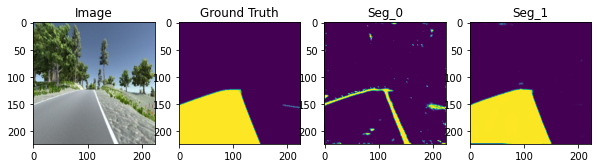

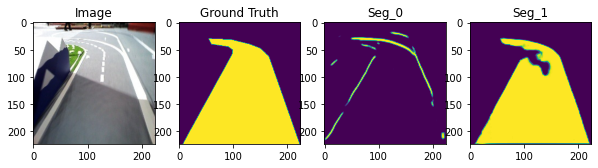

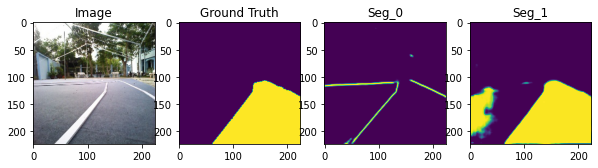

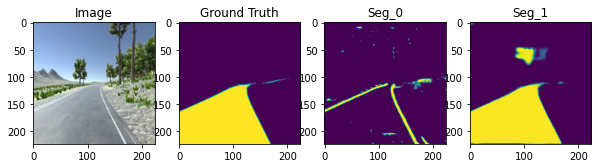

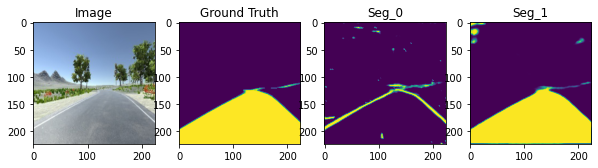

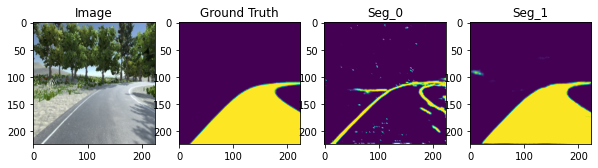

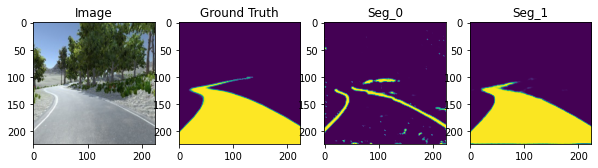

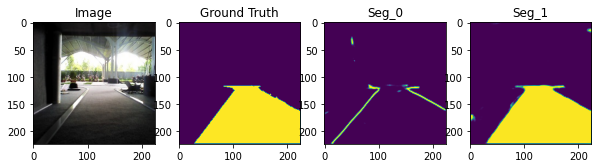

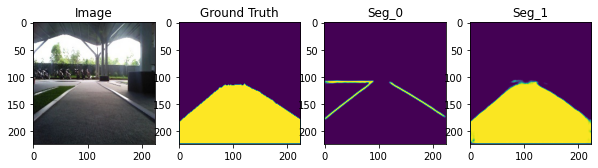

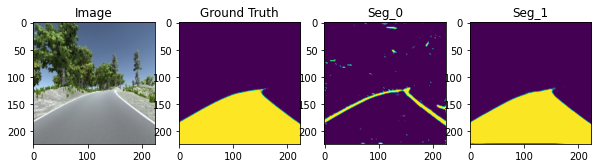

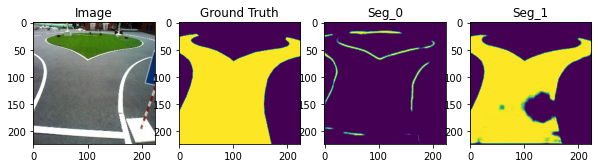

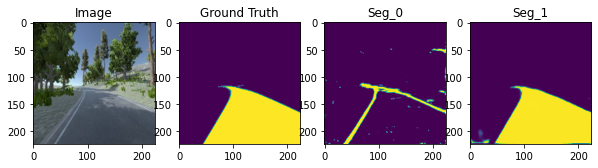

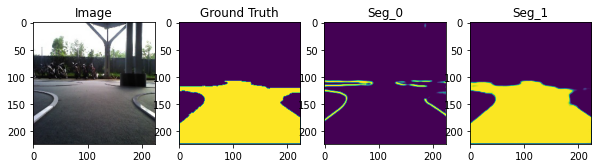

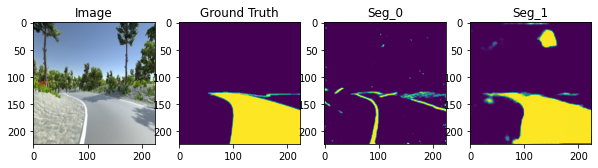

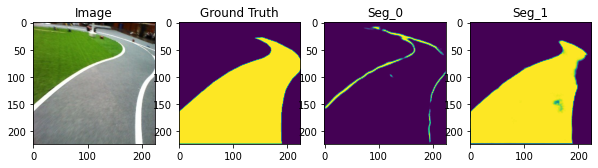

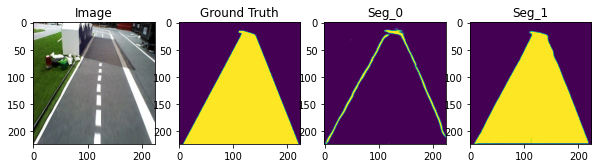

In [ ]:
for _ in range(20):

  img, gt = random.choice(dira)

  img = img.unsqueeze(0).to(DEVICE)

  pred_0, pred_1 = model(img)
  pred_0 = pred_0[0]
  pred_1 = pred_1[0]
  img = img[0]

  fig, ax = plt.subplots(1, 4, figsize=(10, 5))

  ax[0].imshow(tr.ToPILImage()(img))
  ax[0].set_title('Image')
  ax[1].imshow(tr.ToPILImage()(gt))
  ax[1].set_title('Ground Truth')
  ax[2].imshow(tr.ToPILImage()(pred_0))
  ax[2].set_title('Seg_0')
  ax[3].imshow(tr.ToPILImage()(pred_1))
  ax[3].set_title('Seg_1')


In [ ]:
input_tensor = torch.randn(1,3,224,224).to(DEVICE)

torch.onnx.export(
        model,
        input_tensor,
        'mobilenet_unet.onnx',
        export_params=True,
        opset_version=10,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output_0', 'output_1']
    )

In [ ]:
torch.save(model, 'mobilenet_unet.pth')